# Data Preparation
A lo largo de este notebook se cubre  la tercera fase de la metodología CRIPS-DM, en este caso la extracción de características


1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. <span style="color:#66FF99;">**Preparación de los Datos (Data Preparation)** </span> 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.

En esta fase, los **objetivos** serán varios:

1. Muestreo de las imagenes a emplear para el entrenamiento
2. Extracción de nuevas características en las imágens mediante modelos fundacionales
3. Almacenamiento eficiente como dataset nativo de tensor

## 1. Muestreo de las imágenes 

Dado que solo se harán uso de un subconjunto de las clases segmentadas en el dataset original, es necesario hacer un sampleo de las mismas, de forma que solo seleccionemos las relvantes para nuestro modelo. Para ello, se genra una función que, a partir de la instancia de coco pasada por parámetro se obtengan las ids de las imágenes que contienen la selección de las mismas.

Es importante destacar que, en este caso se tendrá en cuenta también un humbral mínimo, de forma que no se tengan en cuenta instancias para la generación de las máscaras donde las instancias ocupan un número de píxeles ínfimo.

In [1]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

In [2]:
yaml = load_yaml_file()


In [3]:
objetives = yaml["objetive_classes"]
objetives

['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [78]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.join(os.getcwd(),"..", DIR_TRAIN_IMGS)

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=116.19s)
creating index...
index created!


Se buscan obtener los ids de las categorias a capturar, almacenadas en categories:

In [79]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]


Ahora se obtienen el subconjunto de ids de imágenes que contienen al menos una de las categorías:

In [80]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con las clases coindicentes son  {len(img_ids)}")

Las imagenes con las clases coindicentes son  79542


Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento

In [81]:
THRESHOLD = 10000 # En pixeles

images_id_final = []

for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=id_objetives)

    total_mask = 0 


    for ann in ann_ids:
        ann = coco.loadAnns(ann)[0]
        total_mask += np.sum(coco.annToMask(ann))


        if(total_mask > THRESHOLD):
            break
    if(total_mask > THRESHOLD):
        images_id_final.append(img_id)




len(images_id_final)/len(img_ids)

0.7720701013301149

Cabe destacar que con el muestreo realizado el conjunto de instancias es adecuado para entrenar un modelo de las características deseadas, al tener solo en train mas de 60.000 instancias y un total de 10 clases.

Ahora vamos generando las máscaras de los ids obtenidos, de nuevo definiendo un umbral para ignorar los elementos muy pequeños en la imagen, y así obtener numpy arrays de la salida esperada del modelo ya procesada

### 2. Extracción de características con modelos fundacionales

Se hace uso de Fast-Sam para la extracción de nuevas características en la imagen, en este caso la extracción de máscaras mediante prompts con CLIP.

Para ello, en pirmera instancia se genera la carga de librerias necesarias

In [196]:
from fastsam import FastSAM, FastSAMPrompt
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

from clip import load, tokenize
import torch


import time

import torch
import torchvision.transforms as transforms
from PIL import Image

In [83]:
yaml = load_yaml_file()
PATH_MODEL = yaml["dirs"]["models"]["fastSAM"]
DIR_TRAIN_IMAGES =  yaml["dirs"]["imagenes"]["train"]

In [84]:
image_name = "000000000241.jpg"

In [85]:
relative_image_path = os.path.join(os.getcwd(),"..",DIR_TRAIN_IMAGES, image_name)
dir_first_image = os.path.normpath(relative_image_path)
dir_first_image

'c:\\Users\\ruben\\Desktop\\code_tfm\\dataset\\coco\\train2017\\000000000241.jpg'

In [86]:
RELATIVE_DIR_MODEL =  os.path.join(os.getcwd(),"..",PATH_MODEL)
RELATIVE_DIR_MODEL = os.path.normpath(RELATIVE_DIR_MODEL)
RELATIVE_DIR_MODEL

'c:\\Users\\ruben\\Desktop\\code_tfm\\models\\FastSAM-x.pt'

In [87]:
image_result_name = "000000000241_2.jpg"
RESULT_PATH =  os.path.join(os.getcwd(),"..",DIR_TRAIN_IMAGES, image_result_name)

In [88]:


model = FastSAM(RELATIVE_DIR_MODEL)


In [89]:
IMAGE_PATH = dir_first_image
DEVICE = 'cpu'
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

# everything prompt
ann = prompt_process.everything_prompt()
#ann = prompt_process.text_prompt(text='a picture of person')

prompt_process.plot(annotations=ann,output_path=RESULT_PATH,)


image 1/1 c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000000241.jpg: 1024x768 69 objects, 10332.1ms
Speed: 27.6ms preprocess, 10332.1ms inference, 407.2ms postprocess per image at shape (1, 3, 1024, 768)


In [90]:
ann.shape

torch.Size([69, 640, 480])

In [95]:
MODEL_CLIP, preprocess_CLIP = load("ViT-B/32", device="cpu")
device="cpu"

In [97]:
classes_names = yaml["objetive_classes"]
classes_names

['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [195]:
image = Image.open(dir_first_image)
image_input = preprocess_CLIP(image).unsqueeze(0).to(device)

AttributeError: 'JpegImageFile' object has no attribute 'shape'

In [99]:
import clip

In [100]:
text_inputs = torch.cat([clip.tokenize(f"a photo of {class_name}") for class_name in classes_names]).to(device)


In [101]:
with torch.no_grad():
    image_features = MODEL_CLIP.encode_image(image_input)
    text_features = MODEL_CLIP.encode_text(text_inputs)

In [102]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (image_features @ text_features.T).squeeze(0)

In [103]:
confidence_threshold = 0.5

In [104]:
best_class_idx = similarity.argmax().item()
best_class = classes_names[best_class_idx]

In [105]:
if similarity[best_class_idx] < confidence_threshold:
    best_class = "fondo"

In [106]:
print(f"La clase predicha para esta máscara es: {best_class}")


La clase predicha para esta máscara es: fondo


In [207]:
sum(similarity)

tensor(2.3628)

In [108]:
classes_names

['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [118]:
np.array(image).shape

(640, 480, 3)

image 1/1 c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000000241.jpg: 1024x768 69 objects, 6242.7ms
Speed: 13.2ms preprocess, 6242.7ms inference, 180.7ms postprocess per image at shape (1, 3, 1024, 768)


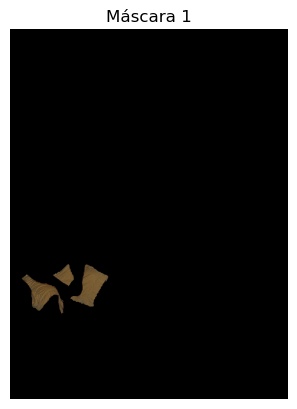

Resultados obtenidos por CLIP:
('person', 0.267)
('car', 0.24)
('motorcycle', 0.243)
('bus', 0.239)
('traffic light', 0.218)
('backpack', 0.244)
('handbag', 0.236)
('cell phone', 0.243)
('chair', 0.253)
('dining table', 0.243)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2669, 0.2404, 0.2432, 0.2390, 0.2182, 0.2441, 0.2364, 0.2426, 0.2529, 0.2430])


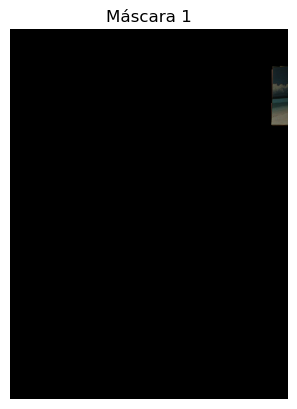

Resultados obtenidos por CLIP:
('person', 0.251)
('car', 0.235)
('motorcycle', 0.232)
('bus', 0.232)
('traffic light', 0.236)
('backpack', 0.24)
('handbag', 0.223)
('cell phone', 0.238)
('chair', 0.236)
('dining table', 0.232)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2508, 0.2352, 0.2320, 0.2316, 0.2356, 0.2396, 0.2229, 0.2381, 0.2362, 0.2315])


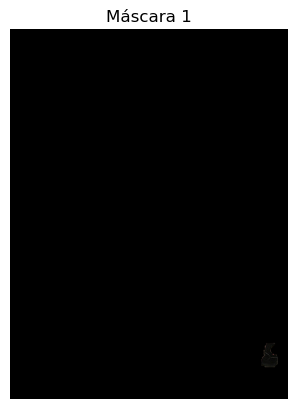

Resultados obtenidos por CLIP:
('person', 0.25)
('car', 0.236)
('motorcycle', 0.233)
('bus', 0.23)
('traffic light', 0.225)
('backpack', 0.248)
('handbag', 0.229)
('cell phone', 0.226)
('chair', 0.241)
('dining table', 0.228)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2500, 0.2355, 0.2326, 0.2302, 0.2251, 0.2480, 0.2294, 0.2256, 0.2411, 0.2281])


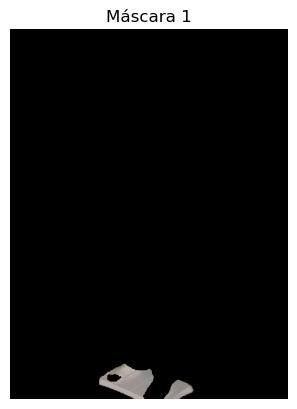

Resultados obtenidos por CLIP:
('person', 0.263)
('car', 0.243)
('motorcycle', 0.248)
('bus', 0.236)
('traffic light', 0.223)
('backpack', 0.249)
('handbag', 0.233)
('cell phone', 0.236)
('chair', 0.248)
('dining table', 0.236)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2632, 0.2432, 0.2483, 0.2356, 0.2231, 0.2486, 0.2333, 0.2357, 0.2478, 0.2358])


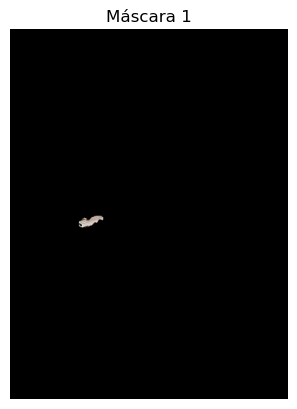

Resultados obtenidos por CLIP:
('person', 0.26)
('car', 0.246)
('motorcycle', 0.248)
('bus', 0.236)
('traffic light', 0.246)
('backpack', 0.251)
('handbag', 0.231)
('cell phone', 0.24)
('chair', 0.244)
('dining table', 0.239)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2598, 0.2458, 0.2476, 0.2357, 0.2464, 0.2511, 0.2313, 0.2401, 0.2438, 0.2392])


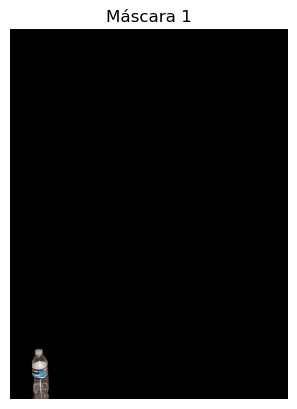

Resultados obtenidos por CLIP:
('person', 0.253)
('car', 0.236)
('motorcycle', 0.235)
('bus', 0.23)
('traffic light', 0.227)
('backpack', 0.241)
('handbag', 0.221)
('cell phone', 0.234)
('chair', 0.237)
('dining table', 0.236)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2526, 0.2356, 0.2354, 0.2295, 0.2275, 0.2411, 0.2207, 0.2338, 0.2370, 0.2359])


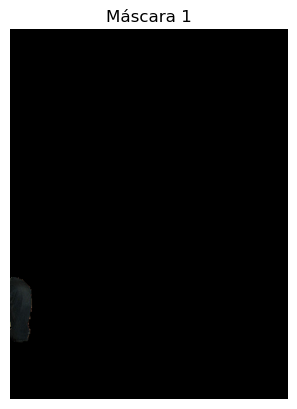

Resultados obtenidos por CLIP:
('person', 0.261)
('car', 0.25)
('motorcycle', 0.25)
('bus', 0.238)
('traffic light', 0.235)
('backpack', 0.26)
('handbag', 0.24)
('cell phone', 0.236)
('chair', 0.253)
('dining table', 0.244)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2613, 0.2500, 0.2504, 0.2376, 0.2354, 0.2597, 0.2396, 0.2356, 0.2533, 0.2435])


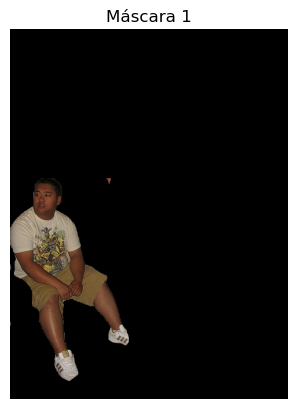

Resultados obtenidos por CLIP:
('person', 0.245)
('car', 0.231)
('motorcycle', 0.241)
('bus', 0.229)
('traffic light', 0.234)
('backpack', 0.243)
('handbag', 0.227)
('cell phone', 0.231)
('chair', 0.24)
('dining table', 0.218)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2451, 0.2310, 0.2409, 0.2295, 0.2339, 0.2428, 0.2274, 0.2305, 0.2395, 0.2180])


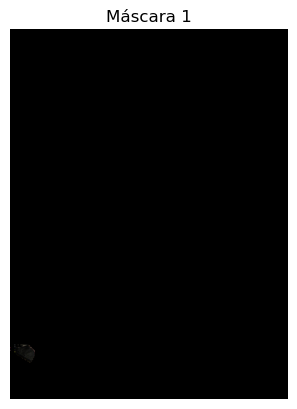

Resultados obtenidos por CLIP:
('person', 0.265)
('car', 0.246)
('motorcycle', 0.247)
('bus', 0.237)
('traffic light', 0.235)
('backpack', 0.251)
('handbag', 0.236)
('cell phone', 0.24)
('chair', 0.245)
('dining table', 0.236)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2651, 0.2464, 0.2474, 0.2368, 0.2349, 0.2511, 0.2361, 0.2399, 0.2450, 0.2359])


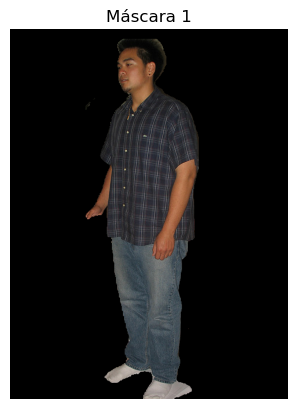

Resultados obtenidos por CLIP:
('person', 0.249)
('car', 0.229)
('motorcycle', 0.24)
('bus', 0.233)
('traffic light', 0.238)
('backpack', 0.241)
('handbag', 0.233)
('cell phone', 0.239)
('chair', 0.237)
('dining table', 0.223)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2494, 0.2293, 0.2400, 0.2330, 0.2384, 0.2407, 0.2325, 0.2394, 0.2367, 0.2234])

Tiempo transcurrido: 11.271358 segundos


In [208]:
resize_transform = transforms.Resize((224, 224))

start_time = time.time()


image_name = "000000000241.jpg"
relative_image_path = os.path.join(os.getcwd(),"..",DIR_TRAIN_IMAGES, image_name)
dir_first_image = os.path.normpath(relative_image_path)
#dir_first_image

image = Image.open(dir_first_image)
image_np = torch.tensor(np.array(image))
image_input = preprocess_CLIP(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of {class_name}") for class_name in classes_names]).to(device) 


IMAGE_PATH = dir_first_image
DEVICE = 'cpu'
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

# everything prompt
ann = prompt_process.everything_prompt()
#ann = prompt_process.text_prompt(text='a picture of person')

with torch.no_grad():
    #image_features = MODEL_CLIP.encode_image(image_input)
    text_features = MODEL_CLIP.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)



start_time_clip = time.time()
for annotation in ann[10:20]:

    result = image_np * annotation[:, :, np.newaxis] 
    plt.imshow(result/255)
    plt.axis('off')
    plt.title("Máscara 1")

    plt.show()
    result = result.permute(2, 0, 1) 
    image_tensor_resized = resize_transform(result)


    
    image_input = image_tensor_resized.to(device).unsqueeze(0)

    with torch.no_grad():
        image_features = MODEL_CLIP.encode_image(image_input)

        
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T).squeeze(0)

    resultados = [(clase, round(float(prob),3)) for clase, prob in zip(classes_names,similarity)]
    print("Resultados obtenidos por CLIP:")
    for elem in resultados:
        print(elem)

    best_class_idx = similarity.argmax().item()
    best_class = classes_names[best_class_idx]
    print(f"Clasificación: ",best_class)
    print(classes_names)
    print(similarity)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTiempo transcurrido: {elapsed_time:.6f} segundos")
    

In [209]:
from torchvision.transforms import ToPILImage
from PIL import Image

image 1/1 c:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000000241.jpg: 1024x768 69 objects, 6054.3ms
Speed: 12.3ms preprocess, 6054.3ms inference, 173.6ms postprocess per image at shape (1, 3, 1024, 768)


torch.Size([3, 640, 480])


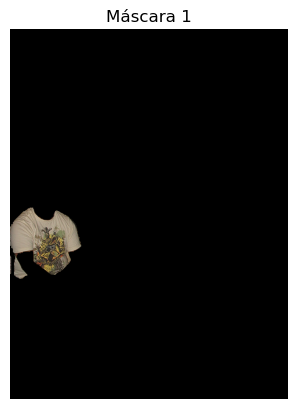

Resultados obtenidos por CLIP:
('person', 0.234)
('car', 0.22)
('motorcycle', 0.23)
('bus', 0.219)
('traffic light', 0.223)
('backpack', 0.255)
('handbag', 0.232)
('cell phone', 0.227)
('chair', 0.223)
('dining table', 0.209)
Clasificación:  backpack
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2345, 0.2203, 0.2303, 0.2187, 0.2228, 0.2555, 0.2323, 0.2271, 0.2231, 0.2085])
torch.Size([3, 640, 480])


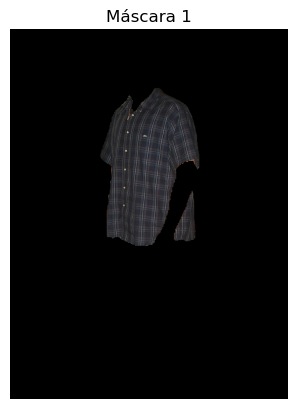

Resultados obtenidos por CLIP:
('person', 0.261)
('car', 0.225)
('motorcycle', 0.225)
('bus', 0.22)
('traffic light', 0.213)
('backpack', 0.263)
('handbag', 0.221)
('cell phone', 0.23)
('chair', 0.224)
('dining table', 0.225)
Clasificación:  backpack
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2613, 0.2247, 0.2250, 0.2200, 0.2131, 0.2632, 0.2207, 0.2304, 0.2236, 0.2253])
torch.Size([3, 640, 480])


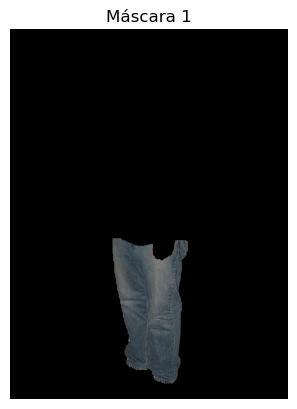

Resultados obtenidos por CLIP:
('person', 0.276)
('car', 0.236)
('motorcycle', 0.236)
('bus', 0.233)
('traffic light', 0.226)
('backpack', 0.269)
('handbag', 0.255)
('cell phone', 0.254)
('chair', 0.259)
('dining table', 0.222)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2756, 0.2365, 0.2361, 0.2329, 0.2261, 0.2690, 0.2546, 0.2538, 0.2592, 0.2219])
torch.Size([3, 640, 480])


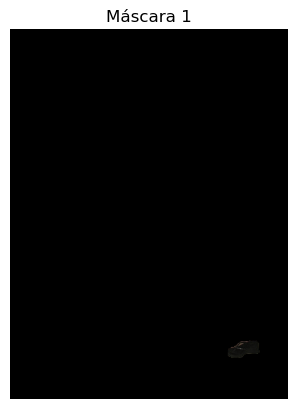

Resultados obtenidos por CLIP:
('person', 0.241)
('car', 0.234)
('motorcycle', 0.239)
('bus', 0.235)
('traffic light', 0.236)
('backpack', 0.236)
('handbag', 0.223)
('cell phone', 0.242)
('chair', 0.232)
('dining table', 0.224)
Clasificación:  cell phone
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2412, 0.2338, 0.2395, 0.2354, 0.2358, 0.2360, 0.2234, 0.2416, 0.2321, 0.2237])
torch.Size([3, 640, 480])


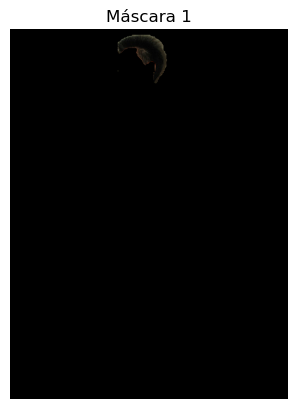

Resultados obtenidos por CLIP:
('person', 0.258)
('car', 0.237)
('motorcycle', 0.241)
('bus', 0.24)
('traffic light', 0.247)
('backpack', 0.25)
('handbag', 0.233)
('cell phone', 0.249)
('chair', 0.247)
('dining table', 0.23)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2585, 0.2369, 0.2415, 0.2403, 0.2471, 0.2497, 0.2327, 0.2490, 0.2470, 0.2302])
torch.Size([3, 640, 480])


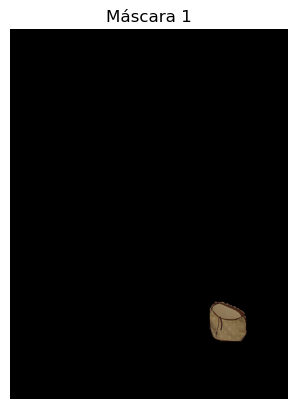

Resultados obtenidos por CLIP:
('person', 0.24)
('car', 0.229)
('motorcycle', 0.235)
('bus', 0.232)
('traffic light', 0.219)
('backpack', 0.259)
('handbag', 0.257)
('cell phone', 0.246)
('chair', 0.251)
('dining table', 0.245)
Clasificación:  backpack
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2399, 0.2285, 0.2346, 0.2316, 0.2191, 0.2588, 0.2570, 0.2456, 0.2508, 0.2449])
torch.Size([3, 640, 480])


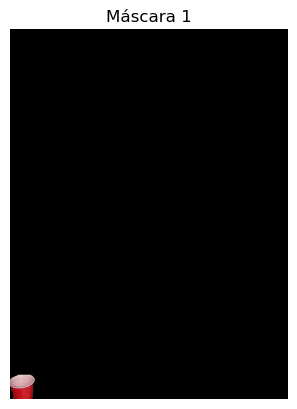

Resultados obtenidos por CLIP:
('person', 0.26)
('car', 0.241)
('motorcycle', 0.247)
('bus', 0.241)
('traffic light', 0.25)
('backpack', 0.252)
('handbag', 0.242)
('cell phone', 0.263)
('chair', 0.251)
('dining table', 0.25)
Clasificación:  cell phone
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2599, 0.2410, 0.2473, 0.2415, 0.2497, 0.2515, 0.2417, 0.2625, 0.2512, 0.2502])
torch.Size([3, 640, 480])


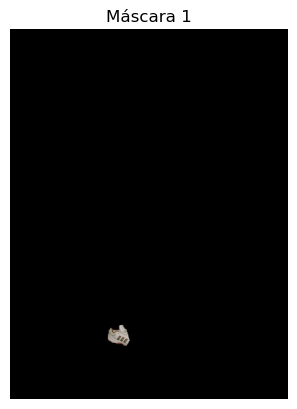

Resultados obtenidos por CLIP:
('person', 0.259)
('car', 0.242)
('motorcycle', 0.247)
('bus', 0.242)
('traffic light', 0.24)
('backpack', 0.263)
('handbag', 0.248)
('cell phone', 0.254)
('chair', 0.259)
('dining table', 0.244)
Clasificación:  backpack
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2586, 0.2417, 0.2469, 0.2422, 0.2405, 0.2627, 0.2485, 0.2539, 0.2590, 0.2444])
torch.Size([3, 640, 480])


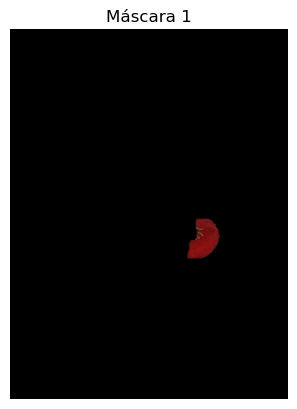

Resultados obtenidos por CLIP:
('person', 0.249)
('car', 0.229)
('motorcycle', 0.238)
('bus', 0.23)
('traffic light', 0.246)
('backpack', 0.236)
('handbag', 0.234)
('cell phone', 0.244)
('chair', 0.249)
('dining table', 0.234)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2490, 0.2287, 0.2383, 0.2302, 0.2460, 0.2363, 0.2341, 0.2436, 0.2489, 0.2343])
torch.Size([3, 640, 480])


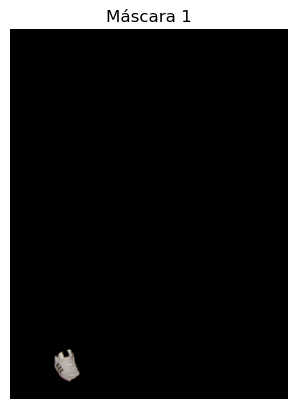

Resultados obtenidos por CLIP:
('person', 0.255)
('car', 0.238)
('motorcycle', 0.244)
('bus', 0.239)
('traffic light', 0.243)
('backpack', 0.244)
('handbag', 0.236)
('cell phone', 0.25)
('chair', 0.249)
('dining table', 0.243)
Clasificación:  person
['person', 'car', 'motorcycle', 'bus', 'traffic light', 'backpack', 'handbag', 'cell phone', 'chair', 'dining table']
tensor([0.2551, 0.2380, 0.2441, 0.2385, 0.2428, 0.2440, 0.2357, 0.2500, 0.2488, 0.2427])

Tiempo transcurrido: 10.499981 segundos


In [217]:
resize_transform = transforms.Resize((224, 224))

start_time = time.time()


image_name = "000000000241.jpg"
relative_image_path = os.path.join(os.getcwd(),"..",DIR_TRAIN_IMAGES, image_name)
dir_first_image = os.path.normpath(relative_image_path)
#dir_first_image

image = Image.open(dir_first_image)
image_np = torch.tensor(np.array(image))
image_input = preprocess_CLIP(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of {class_name}") for class_name in classes_names]).to(device) 


IMAGE_PATH = dir_first_image
DEVICE = 'cpu'
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

# everything prompt
ann = prompt_process.everything_prompt()
#ann = prompt_process.text_prompt(text='a picture of person')

with torch.no_grad():
    #image_features = MODEL_CLIP.encode_image(image_input)
    text_features = MODEL_CLIP.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)



start_time_clip = time.time()
for annotation in ann[0:10]:

    result = image_np * annotation[:, :, np.newaxis]

    tensor_rearranged = result.permute(2, 0, 1)

    
    result = tensor_rearranged.byte()

    print(result.shape)

    to_pil = ToPILImage()

    result = to_pil(result)

    image_tensor = preprocess_CLIP(result).unsqueeze(0).to(device)

    
    plt.imshow(result)
    plt.axis('off')
    plt.title("Máscara 1")

    plt.show()


    with torch.no_grad():
        image_features = MODEL_CLIP.encode_image(image_tensor)

        
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T).squeeze(0)

    resultados = [(clase, round(float(prob),3)) for clase, prob in zip(classes_names,similarity)]
    print("Resultados obtenidos por CLIP:")
    for elem in resultados:
        print(elem)

    best_class_idx = similarity.argmax().item()
    best_class = classes_names[best_class_idx]
    print(f"Clasificación: ",best_class)
    print(classes_names)
    print(similarity)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTiempo transcurrido: {elapsed_time:.6f} segundos")
    

In [ ]:
otras_imgs = ["000000007819.jpg", "000000004554.jpg"]